In [22]:
import pandas as pd
from pandas_tfrecords import pd2tf 
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
def save_data_as_tfrecords(data_source, output_path):
    df = pd.read_csv(data_source)
    pd2tf(df, output_path)
    print('Saved data as tfrecords at {}'.format(output_path))
    return df


In [11]:
data_source = 'data/covid.zip'

df = save_data_as_tfrecords(data_source, 'data/covid.tfrecords')
df.head()

Saved data as tfrecords at data/covid.tfrecords


,headlines,outcome
0,A post claims compulsory vacination violates t...,0
1,A photo claims that this person is a doctor wh...,0
2,Post about a video claims that it is a protest...,0
3,All deaths by respiratory failure and pneumoni...,0
4,The dean of the College of Biologists of Euska...,0


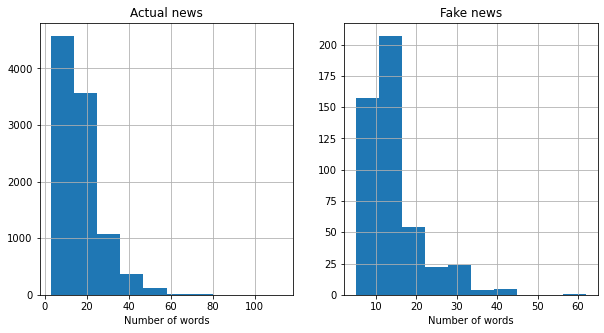

In [31]:
# create two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

titles = ['Actual news', 'Fake news']
for i, title in enumerate(titles):
    df.query('outcome == @i')['headlines'].str.split().\
        map(lambda x: len(x)).hist(ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel('Number of words')
plt.show()

In [ ]:
import tensorflow as tf

# read tfrecords
def read_tfrecords(tfrecords_path, batch_size, shuffle_buffer_size=1000):
    def decode(x):
        feature_description = {
            'headlines': tf.io.FixedLenFeature([], tf.string),
            'outcome': tf.io.FixedLenFeature([], tf.int64),
        }
        return tf.io.parse_single_example(x, feature_description)
    
    def get_dataset(tfrecords_path):
        dataset = tf.data.TFRecordDataset(tfrecords_path)
        dataset = dataset.map(decode)
        return dataset
    
    dataset = get_dataset(tfrecords_path)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    return dataset

In [27]:
import tensorflow as tf 
import boto3, os
import pandas as pd

class DataUploader:
    def __init__(self, data_source: str, output_path: str, batch_size: int, bucket_name: str):
        self.data_source = data_source
        self.batch_size = batch_size
        self.output_path = output_path
        self.bucket = boto3.resource('s3', region_name='ap-southeast-1').Bucket(bucket_name)

    @staticmethod
    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    @staticmethod
    def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))
    
    @staticmethod
    def write_single_tfrecord_file(df, output_path:str, file_index:int):
        output_path = output_path + f'/file_{file_index}.tfrecords'
        with tf.io.TFRecordWriter(output_path) as writer:
            for _, row in df.iterrows():
                feature = {
                    'headlines': DataUploader._bytes_feature(row['headlines']),
                    'outcome': DataUploader._int64_feature(row['outcome']),
                }
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())


    def write_tfrecords(self):
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
        df = pd.read_csv(self.data_source)
        num_rows = len(df)
        num_files = num_rows // self.batch_size

        for i in range(num_files):
            self.write_single_tfrecord_file(df.iloc[i*self.batch_size:(i+1)*self.batch_size], self.output_path, i)
            print('Wrote {} rows to tfrecords file {}'.format(self.batch_size, i))

    def upload_to_s3(self):
        # upload all files in directory
        for file in os.listdir(self.output_path):
            key = os.path.join(self.output_path, file)
            self.bucket.upload_file(key, key)

    
        

In [28]:
data_uploader = DataUploader('data/covid.zip', 'data/covid.tfrecords', 310, 'xy-mp-pipeline')
data_uploader.write_tfrecords()
data_uploader.upload_to_s3()

Wrote 310 rows to tfrecords file 0
Wrote 310 rows to tfrecords file 1
Wrote 310 rows to tfrecords file 2
Wrote 310 rows to tfrecords file 3
Wrote 310 rows to tfrecords file 4
Wrote 310 rows to tfrecords file 5
Wrote 310 rows to tfrecords file 6
Wrote 310 rows to tfrecords file 7
Wrote 310 rows to tfrecords file 8
Wrote 310 rows to tfrecords file 9
Wrote 310 rows to tfrecords file 10
Wrote 310 rows to tfrecords file 11
Wrote 310 rows to tfrecords file 12
Wrote 310 rows to tfrecords file 13
Wrote 310 rows to tfrecords file 14
Wrote 310 rows to tfrecords file 15
Wrote 310 rows to tfrecords file 16
Wrote 310 rows to tfrecords file 17
Wrote 310 rows to tfrecords file 18
Wrote 310 rows to tfrecords file 19
Wrote 310 rows to tfrecords file 20
Wrote 310 rows to tfrecords file 21
Wrote 310 rows to tfrecords file 22
Wrote 310 rows to tfrecords file 23
Wrote 310 rows to tfrecords file 24
Wrote 310 rows to tfrecords file 25
Wrote 310 rows to tfrecords file 26
Wrote 310 rows to tfrecords file 27
Wr

In [1]:
DATA_SOURCE = 'data/covid.zip'
BUCKET_NAME = 'xy-mp-pipeline'
OUTPUT_PATH = 'data/covid.tfrecords'
BATCH_SIZE = 310

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_io

tf.get_logger().setLevel('ERROR')

C:\Users\Xin Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 310
seed = 42



def get_dataset(batch_size, bucket_name, s3_prefix):
    def parse_tfrecord(example_proto):
        feature_description = {
            'headlines': tf.io.FixedLenFeature([], tf.string),
            'outcome': tf.io.FixedLenFeature([], tf.int64),
        }
        return tensorflow_io.parse_single_example(example_proto, feature_description)
    
    autotune = tf.data.experimental.AUTOTUNE
    records = tf.data.Dataset.list_files(f's3://{bucket_name}/{s3_prefix}/*.tfrecords', shuffle=True)
    dataset = tf.data.TFRecordDataset(records, num_parallel_reads=autotune).repeat()
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=autotune)
    dataset = dataset.batch(batch_size).prefetch(autotune)
    return dataset

train_dataset = get_dataset(batch_size, BUCKET_NAME, 'data/covid.tfrecords')
# 
